In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/boxing-matches-dataset-predict-winner/fighters.csv
/kaggle/input/boxing-matches-dataset-predict-winner/popular_matches.csv


In [2]:
# Reading csv
matches = pd.read_csv('/kaggle/input/boxing-matches-dataset-predict-winner/popular_matches.csv')
fighters = pd.read_csv('/kaggle/input/boxing-matches-dataset-predict-winner/fighters.csv')

# Data Cleaning
## Fighters
First five rows of the fighters dataframe

In [3]:
fighters.head()

,name,wins,looses,draws,ko_rate,stance,age,height,reach,country
0,Azizbek Abdumuxtar Abdugofurov,0,0,0,0%,Orthodox,Unknown,Unknown,Unknown,Uzbekistan
1,Franco Fernando Altamiranda,0,0,0,0%,Orthodox,Unknown,Unknown,Unknown,Argentina
2,Joaquin Saul Alvarez,0,0,0,0%,Orthodox,Unknown,Unknown,Unknown,"Venezuela, Bolivarian Republic of"
3,Saul Alvarez,54,1,2,63.2%,Orthodox,32,5.74 ft (1.75 m),70.47 inches (179 cm),Mexico
4,Sukru Altay,0,0,0,0%,Orthodox,38,Unknown,Unknown,Germany


**Statistical summary** of the numeric variables of fighters

In [4]:
fighters.describe()

,wins,looses,draws
count,2760.000000,2760.000000,2760.000000
mean,19.673188,4.489493,0.956522
std,29.494799,10.041301,2.876004
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,9.000000,1.000000,0.000000
75%,28.000000,5.000000,1.000000
max,262.000000,190.000000,60.000000


**Info** of fighters (data type, null count, shape)

In [5]:
fighters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760 entries, 0 to 2759
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     2760 non-null   object
 1   wins     2760 non-null   int64 
 2   looses   2760 non-null   int64 
 3   draws    2760 non-null   int64 
 4   ko_rate  2760 non-null   object
 5   stance   2760 non-null   object
 6   age      2760 non-null   object
 7   height   2760 non-null   object
 8   reach    2760 non-null   object
 9   country  2760 non-null   object
dtypes: int64(3), object(7)
memory usage: 215.8+ KB


Deleting fighters without any fight (usless for the model) and calculating percent missing

In [6]:
# Deleting fighters without any fight or with low wins
index = fighters[(fighters.wins < 5) | ((fighters.wins == 0) & (fighters.looses == 0) & (fighters.draws == 0))].index
fighters_clean = fighters.drop(index)

# Caltulating percent missing
fighters_clean.replace('Unknown',np.nan,inplace=True)
total_missing = fighters_clean.isnull().sum().sum()
total_cells = np.product(fighters_clean.shape)
percent_missing = (total_missing/total_cells)

# Printing results
print(f'Fighters shape: {fighters.shape}')
print(f'Fighters clean shape: {fighters_clean.shape}')
print(f'Rows deleted: {fighters.shape[0] - fighters_clean.shape[0]}')

print(f'\nPercent missing data: {percent_missing:.2%}')

Fighters shape: (2760, 10)
Fighters clean shape: (1469, 10)
Rows deleted: 1291

Percent missing data: 10.61%


## Formating
In several columns, there are info without the right format, and with useless data that we don't need, it needs to be cleaned, some examples are:

**Ko rate**
Original: 63.3% Formated: 63.3

**Height**
Original: 5.74 ft (1.75 m) Formated: 1.75

**Reach**
Original: 70.47 inches (179 cm) Formated: 179

In [7]:
# Deleting % from all the ko_rate column
fighters_clean.ko_rate = fighters_clean.ko_rate.map(lambda ko: ko[:ko.index('%')])
# Converting ko_rate 'object' to 'float64'
fighters_clean.ko_rate = fighters_clean.ko_rate.astype('float64')

# Converting age 'object' to 'Int64'
fighters_clean.age = fighters_clean.age.astype('Int64')

# Function to obtain only the height
def height_float(height):
    try:
        if type(height) == str: 
            i1 = height.index('(')
            i2 = height.index('m')
            return height[i1+1:i2-1]
        # Pass null values
        else: pass
    # Handling an exception because there was a date in the height
    except: 
        return np.nan
fighters_clean.height = fighters_clean.height.map(height_float)

# Converting height 'object' to 'float64'
fighters_clean.height = fighters_clean.height.astype('float64')

# Function to obtain only the reach
def reach_float(reach):
        if type(reach) == str and reach[5] == 'f':
            i1 = reach.index('(')
            i2 = reach.index('m')
            n = reach[i1+1:i2-1]
            return float(n) *100
        elif type(reach) == str: 
            i1 = reach.index('(')
            i2 = reach.index('m')
            n = reach[i1+1:i2-2]
            return n
        # Pass null values
        else: pass
fighters_clean.reach = fighters_clean.reach.map(reach_float)

# Converting reach 'object' to 'float64'
fighters_clean.reach = fighters_clean.reach.astype('float64')

# There was an incorrect entry for country, I changed it to the more common one, which was United States.
fighters_clean.country = fighters_clean.country.replace('75.20 inches (191 cm)','United States')

# Converting fighters names to minuscules
fighters_clean.name = fighters_clean.name.str.lower()

# Now we have all the data cleaned, in its corresponding format
fighters_clean.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,name,wins,looses,draws,ko_rate,stance,age,height,reach,country
3,saul alvarez,54,1,2,63.2,Orthodox,32,1.75,179.0,Mexico
6,rene alvarado,32,8,0,52.5,Orthodox,33,1.70,183.0,Nicaragua
7,armando alvarez,20,2,0,54.5,Orthodox,33,1.84,NaN,United States
9,chris alvarado,13,6,0,31.6,Orthodox,57,1.75,NaN,United States
12,daniel alicea,30,7,2,56.4,Orthodox,49,1.73,178.0,Puerto Rico


## Matches
First five rows of the fighters dataframe

In [8]:
matches.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,date,place,opponent_1,opponent_2,opponent_1_estimated_punch_power,opponent_2_estimated_punch_power,opponent_1_estimated_punch_resistance,opponent_2_estimated_punch_resistance,opponent_1_estimated_ability_to_take_punch,opponent_2_estimated_ability_to_take_punch,opponent_1_rounds_boxed,opponent_2_rounds_boxed,opponent_1_round_ko_percentage,opponent_2_round_ko_percentage,opponent_1_has_been_ko_percentage,opponent_2_has_been_ko_percentage,opponent_1_avg_weight,opponent_2_avg_weight,verdict
0,31 August 2019,Unknown,Vasyl Lomachenko,Luke Campbell,72,72,73.9,60.5,78.0,73.0,119,130.0,8.40,12.31,0.00,0.00,127.11,135.24,Lomachenko won via UD in round 12
1,19 September 2019,Unknown,Orlando Fiordigiglio,Sam Eggington,59,59,55.4,54.5,68.0,66.0,200,177.0,6.50,8.47,3.03,6.25,152.50,148.93,Eggington won via KO in round 2
2,5 October 2019,Unknown,Gennady Golovkin,Sergiy Derevyanchenko,82,82,68.0,63.3,84.0,75.0,200,81.0,17.50,12.35,0.00,0.00,159.66,164.04,Golovkin won via UD in round 12
3,12 October 2019,Unknown,Chazz Witherspoon,Oleksandr Usyk,69,69,59.6,68.9,79.0,80.0,182,125.0,15.93,9.60,4.76,NaN,292.71,200.10,Usyk won via RTD in round 7
4,27 September 2019,Unknown,Ebenezer Tetteh,Daniel Dubois,46,46,NaN,44.4,50.0,69.0,38,39.0,23.68,30.77,0.00,0.00,178.67,230.38,Dubois won via TKO in round 1


**Statistical summary** of the numeric variables of fighters

In [9]:
matches.describe()

,opponent_1_estimated_punch_power,opponent_2_estimated_punch_power,opponent_1_estimated_punch_resistance,opponent_2_estimated_punch_resistance,opponent_1_estimated_ability_to_take_punch,opponent_2_estimated_ability_to_take_punch,opponent_1_rounds_boxed,opponent_2_rounds_boxed,opponent_1_round_ko_percentage,opponent_2_round_ko_percentage,opponent_1_has_been_ko_percentage,opponent_2_has_been_ko_percentage,opponent_1_avg_weight,opponent_2_avg_weight
count,152.000000,152.000000,150.000000,144.000000,151.000000,145.000000,152.000000,125.00000,128.000000,134.000000,135.000000,97.000000,151.000000,140.000000
mean,66.289474,66.289474,55.548667,54.899306,69.728477,69.834483,145.263158,121.20000,16.110000,24.407164,4.955556,1.871546,191.799007,191.238000
std,14.909276,14.909276,11.765196,13.052270,15.283513,14.975449,94.208571,83.13873,14.415657,21.224731,8.856130,5.160239,75.580924,79.047377
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,60.000000,50.750000,50.825000,64.500000,63.000000,66.250000,59.00000,8.317500,10.365000,0.000000,0.000000,142.970000,147.122500
50%,69.000000,69.000000,58.000000,58.200000,76.000000,73.000000,135.000000,107.00000,12.205000,15.645000,0.000000,0.000000,178.650000,200.865000
75%,74.000000,74.000000,62.975000,63.075000,79.000000,81.000000,200.750000,170.00000,20.102500,30.770000,6.525000,0.000000,239.135000,237.110000
max,89.000000,89.000000,73.900000,73.400000,86.000000,89.000000,462.000000,391.00000,100.000000,100.000000,62.500000,25.000000,432.860000,661.500000


**Info** of fighters (data type, null count, shape)

In [10]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 19 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        152 non-null    object 
 1   place                                       152 non-null    object 
 2   opponent_1                                  152 non-null    object 
 3   opponent_2                                  152 non-null    object 
 4   opponent_1_estimated_punch_power            152 non-null    int64  
 5   opponent_2_estimated_punch_power            152 non-null    int64  
 6   opponent_1_estimated_punch_resistance       150 non-null    float64
 7   opponent_2_estimated_punch_resistance       144 non-null    float64
 8   opponent_1_estimated_ability_to_take_punch  151 non-null    float64
 9   opponent_2_estimated_ability_to_take_punch  145 non-null    float64
 10  opponent_1_rou

In [11]:
# Deleting column place because it's empty, and punch power because the columns are duplicated
matches_clean = matches.drop(['place', 'opponent_1_estimated_punch_power', 'opponent_2_estimated_punch_power'], axis=1)

# Deleting white spaces from the end of opponents
matches_clean.opponent_1 = matches_clean.opponent_1.str.strip()
matches_clean.opponent_2 = matches_clean.opponent_2.str.strip()

# Correcting bad typing
matches_clean.loc[124,'opponent_1'] = 'Robbie Davies Jr'

# Deleting rows that have all missing (useless) data
matches_clean.drop(matches_clean[matches_clean.date == '8 April 2017'].index, inplace=True)
matches_clean.drop(matches_clean[matches_clean.date == '9 November 2019'].index, inplace=True)
matches_clean.drop(matches_clean[matches_clean.date == '20 August 2016'].index, inplace=True)
matches_clean.drop(matches_clean[matches_clean.date == '21 August 2016'].index, inplace=True)

# Calculating percent missing
total_missing = matches.isnull().sum().sum()
total_cells = np.product(matches.shape)
percent_missing = (total_missing/total_cells)

In [12]:
# Printing results
print(f'Matches shape: {matches.shape}')
print(f'Matches clean shape: {matches_clean.shape}')
print(f'Rows deleted: {matches.shape[0] - matches_clean.shape[0]}')

print(f'\nPercent missing data: {percent_missing:.2%}')

Matches shape: (152, 19)
Matches clean shape: (148, 16)
Rows deleted: 4

Percent missing data: 5.96%


## Creating categories to predict
*Verdict* comes like a long string, something like: 'Lomachenko won via UD in round 12'. It's only needed to knows who won, so *verdict* is converted to the next categories:

* 0 = Opponent 1 win
* 1 = Opponent 2 win
* 2 = Draw

In [13]:
def verdict_cat(df):
    verdict = re.search(r'(\w+)', df.verdict).group()
    opponent_1 = re.search(r'(\w+)$', df.opponent_1).group()
    opponent_2 = re.search(r'(\w+)$', df.opponent_2).group()
    if opponent_1 == 'Jr':
        opponent_1 = re.search(r'(\w+)(?= Jr)', df.opponent_1).group()
    if opponent_2 == 'Jr':
        opponent_2 = re.search(r'(\w+)(?= Jr)', df.opponent_2).group()
    if verdict == 'Draw':
        return(2)
    elif verdict == opponent_1:
        return(0)
    elif verdict == opponent_2:
        return(1)

matches_clean['verdict'] = matches_clean.apply(verdict_cat, axis=1)
matches_clean.verdict = matches_clean.verdict.astype(int)

# Droping draws
matches_clean.drop(matches_clean[matches_clean.verdict == 2].index, inplace=True)

## Mergin the tables
Joining the information of the fighters (height, age, etc) to the corresponding opponents in the matches table

In [14]:
# Converting matches opponents to minuscules
matches_clean.opponent_1 = matches_clean.opponent_1.str.lower()
matches_clean.opponent_2 = matches_clean.opponent_2.str.lower()

# Droping country because we don't need it for predictions
fighters_clean_2 = fighters_clean.drop('country',axis=1)

# Merging tables
# Opponent 1
fighters_op1 = fighters_clean_2.rename(columns=lambda x: f"{x}_op1" if x != 'name' else x)
fighters_matches = pd.merge(matches_clean, fighters_op1, left_on='opponent_1', right_on='name', how='left')

# Opponent 2
fighters_op2 = fighters_clean_2.rename(columns=lambda x: f"{x}_op2" if x != 'name' else x)
fighters_matches = pd.merge(fighters_matches, fighters_op2, left_on='opponent_2', right_on='name', how='left')

# Deleting irrelevant columns
fighters_matches = fighters_matches.drop(['name_x','name_y','date','opponent_1','opponent_2'],axis=1)

# Exploratory Data Analysis
- What type of fighter is most likely to win a fight?
- Wich features are the most important to take in count to win?
- Evaluate correlation
### Fighters distribution

In [15]:
numeric = fighters_clean.select_dtypes(include=['int64', 'float64']).columns

cat = fighters_clean.select_dtypes(include=['object']).columns
cat = cat.drop('name')

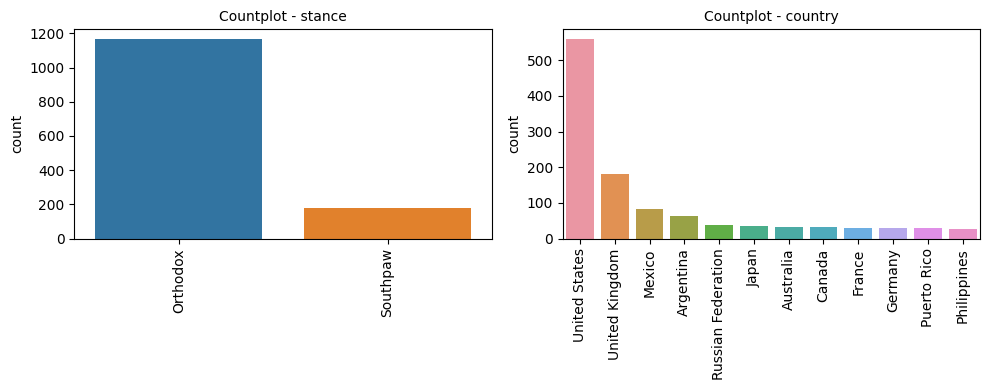

In [16]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes = axes.flatten()

for i, col in enumerate(cat):
    sns.countplot(x=fighters_clean[col], ax=axes[i], order=fighters_clean[col].value_counts().index[:12])
    axes[i].set_title(f'Countplot - {col}', fontsize=10)
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

- The 80% of the fighters have Orthodox stance, the 20% have Southpaw
- United States, United Kingdom and Mexico are the countries with more fighters

### Fighters and matches distribution

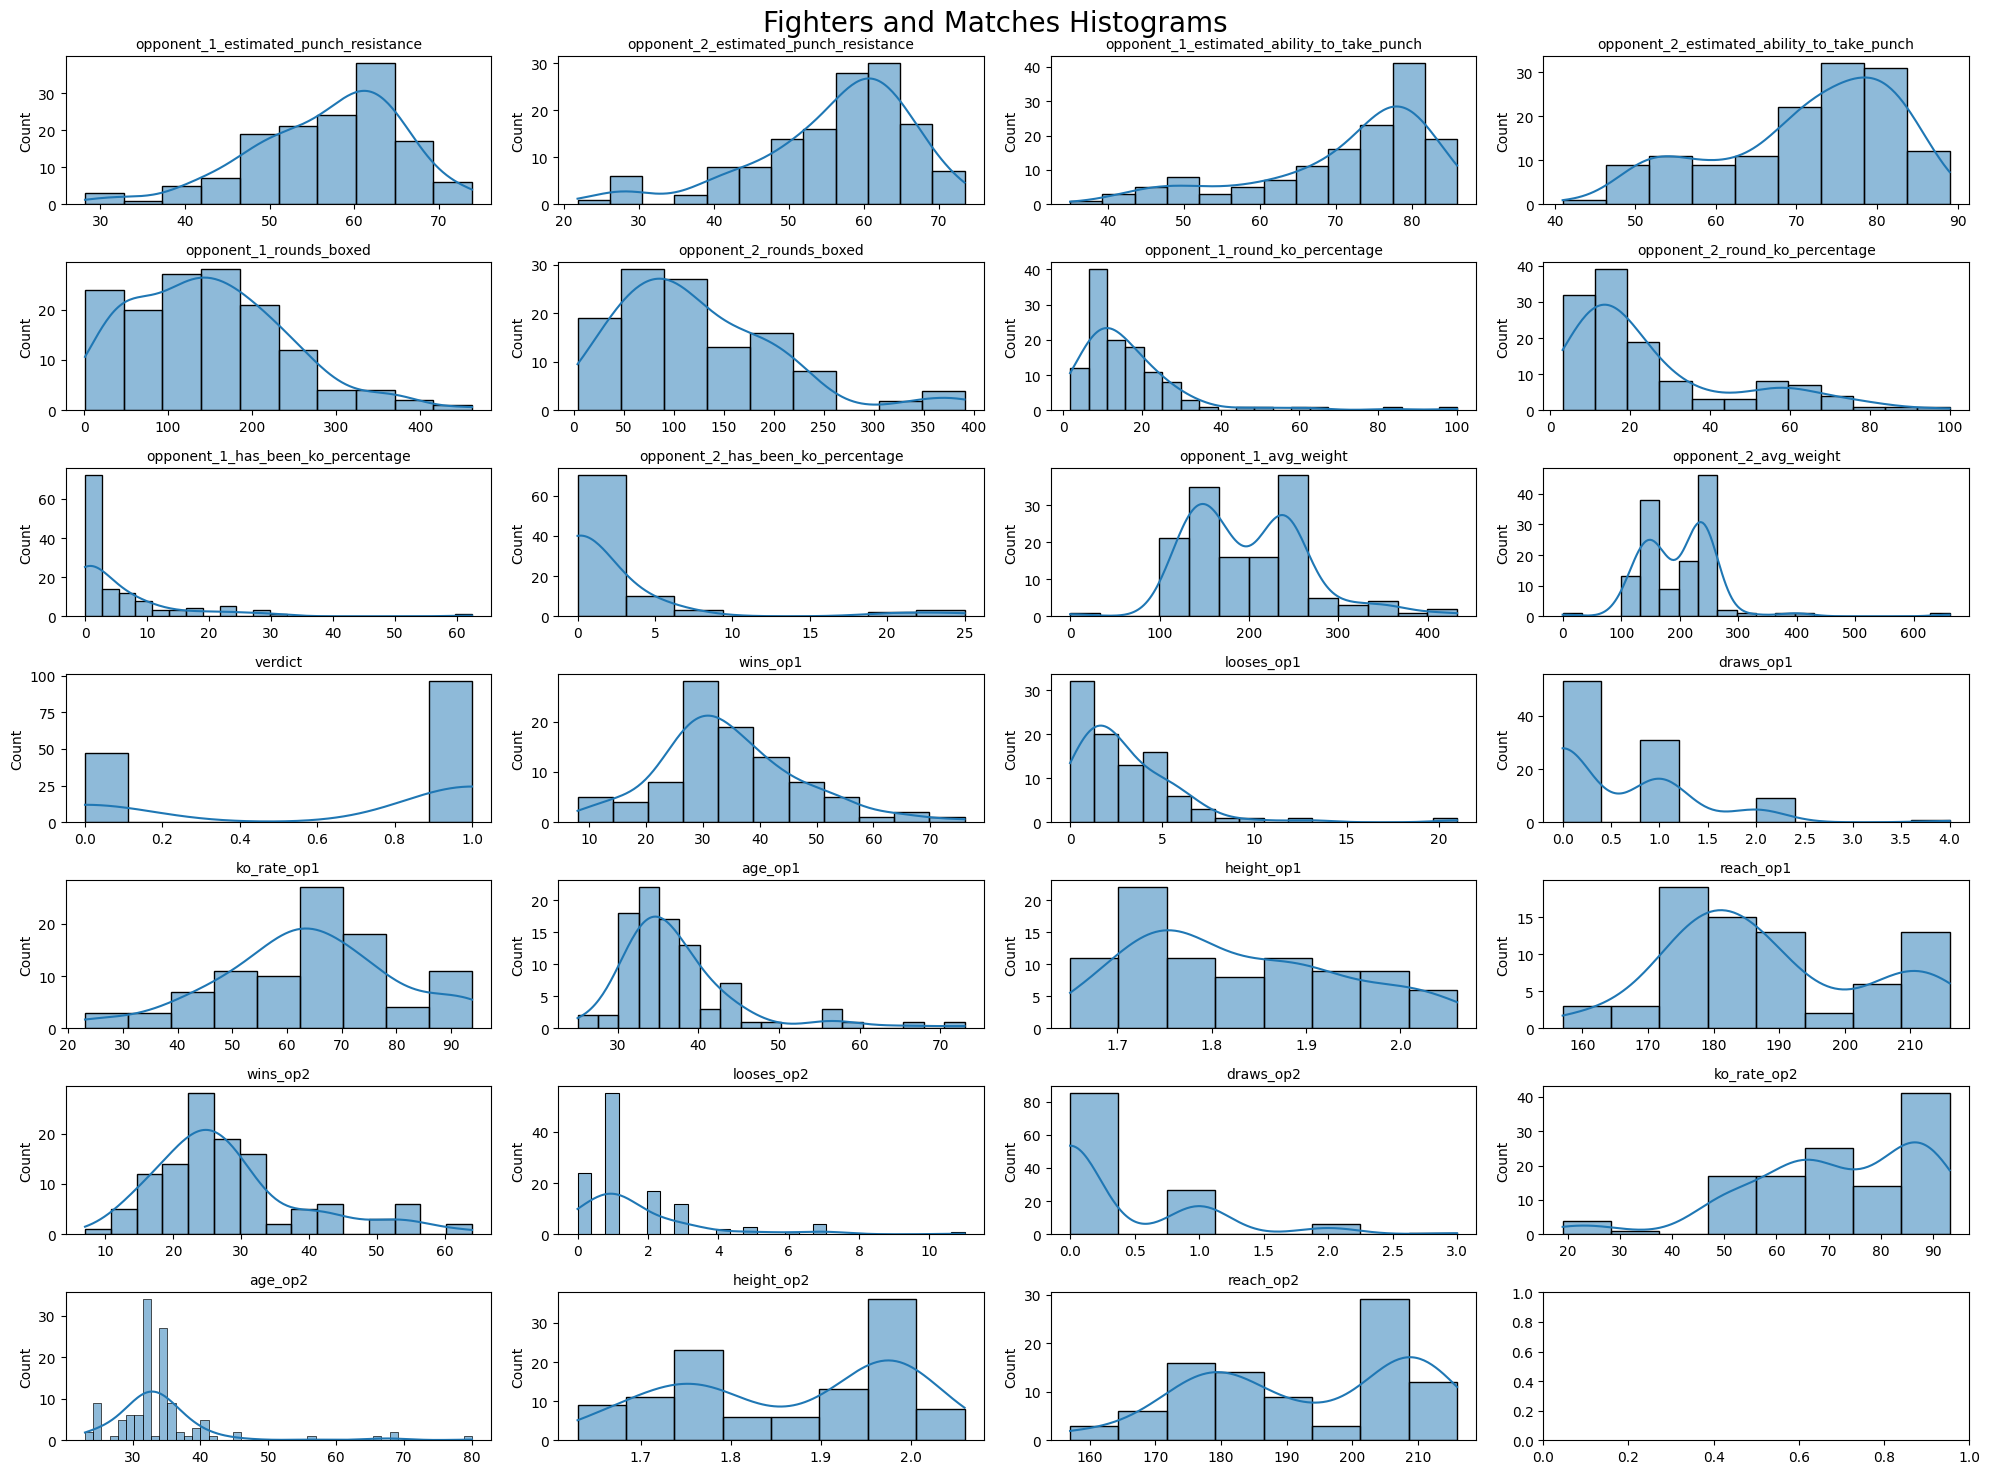

In [17]:
numeric = fighters_matches.select_dtypes(include=['int64', 'float64']).columns

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    fig, axes = plt.subplots(7,4, figsize=(20,15))
    axes = axes.flatten()

    for i, col in enumerate(numeric):
        sns.histplot(x=fighters_matches[col], ax=axes[i], kde=True)
        axes[i].set_title(col, fontsize=10)
        axes[i].set_xlabel('')
    fig.suptitle('Fighters and Matches Histograms', fontsize=20)
    plt.tight_layout()
    plt.show()

### Fighters and matches verdic distribution

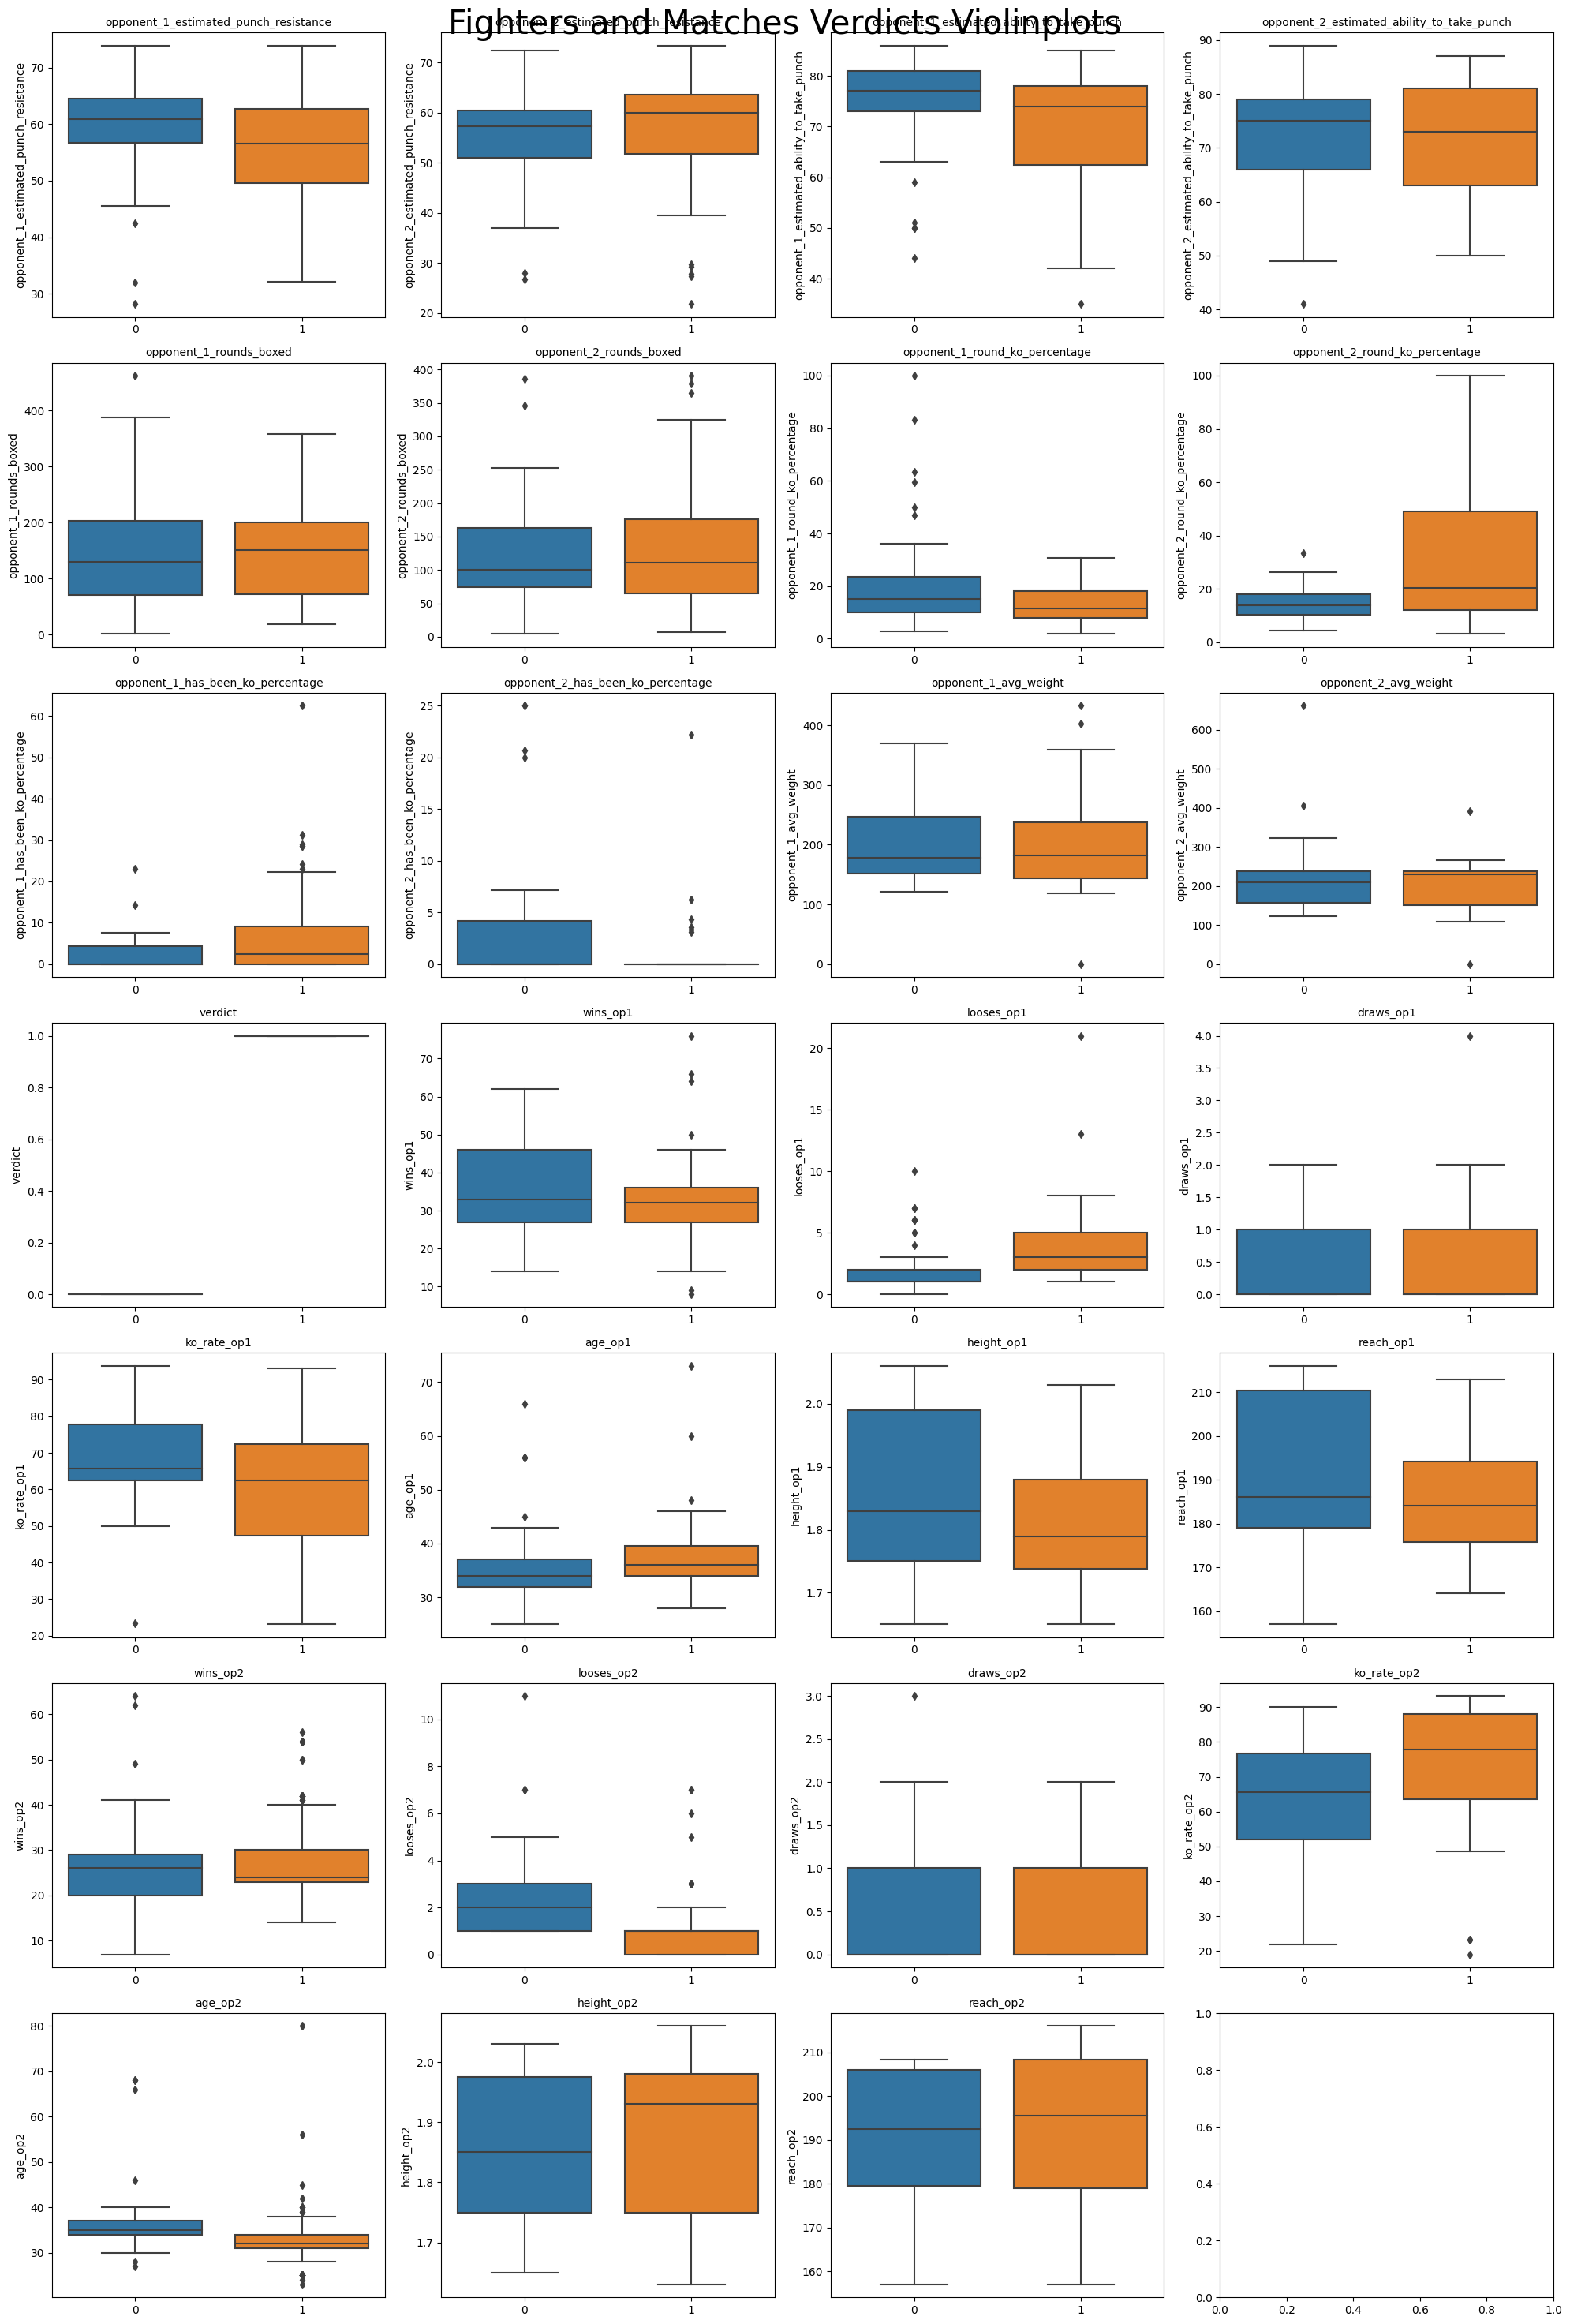

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    fig, axes = plt.subplots(7,4, figsize=(20,30))
    axes = axes.flatten()
    for i, col in enumerate(numeric):
        sns.boxplot(x=fighters_matches['verdict'], y=fighters_matches[col], ax=axes[i])
        axes[i].set_title(col, fontsize=10)
        axes[i].set_xlabel('')
    fig.suptitle('Fighters and Matches Verdicts Violinplots', fontsize=30)
    plt.tight_layout()
    plt.show()

## Observations
**The most relevant variables, in order of importance**

- KO rate: Winners have a considerably higher median (72%) than losers (62%)
- Looses: Winners have a median of 1 loss, while losers have a median of 3
- Has been KO: Winners have a median close to 0%
- Punch resistance: Winners have a considerably higher median (60) than losers (55)
- Round KO: Winners have a moderately higher median (20%) than losers (16%)
- Reach, height, rounds boxed: There are slight differences in the median, but the boxes overlap significantly; they could have a moderate value in interactions with other variables

*The other variables don't seem that important*

### Fighters and matches correlations

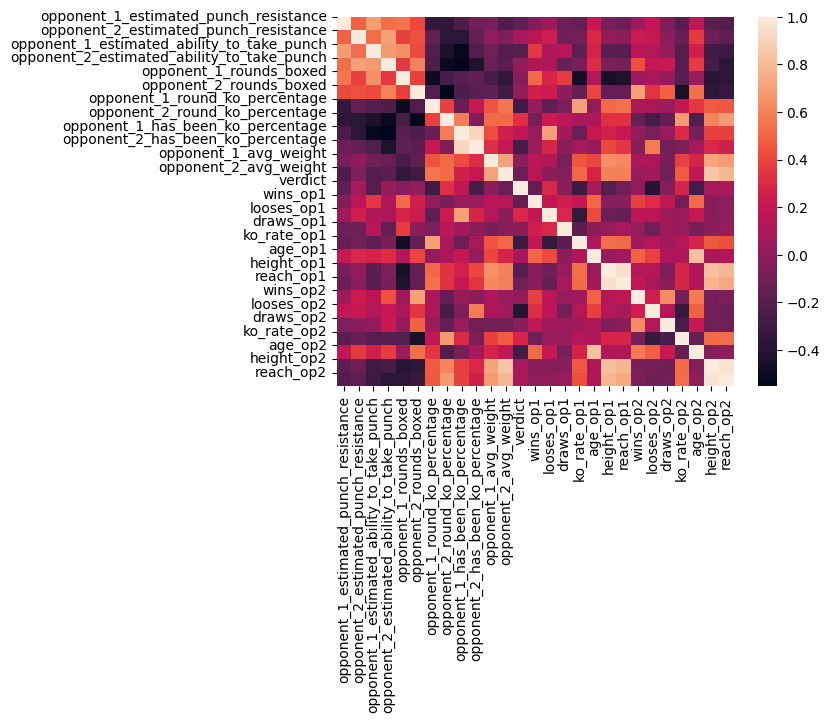

In [19]:
correlations = fighters_matches[numeric].corr()
sns.heatmap(data=correlations)
plt.yticks(ticks=range(len(correlations.columns)), labels=correlations.columns, rotation=0)
plt.show()

## Modeling
Creating a model without any Feature Engineering for references

In [20]:
df = matches.copy()

# Deleting white spaces from the end of opponents
df.opponent_1 = df.opponent_1.str.strip()
df.opponent_2 = df.opponent_2.str.strip()

# Correcting bad typing
df.loc[124,'opponent_1'] = 'Robbie Davies Jr'

# Creating predictors
df['verdict'] = df.apply(verdict_cat, axis=1)
df = df[~df['verdict'].isnull()]
df.verdict = df.verdict.astype(int)

# Droping draws
df.drop(df[df.verdict == 2].index, inplace=True)

# Droping categorical variables
df.drop(['date','place','opponent_1','opponent_2'], axis=1, inplace=True)

In [21]:
X = df.drop('verdict', axis=1)
X.fillna(0, inplace=True)
y = df.verdict

### F1 Score Simple Decision Tree Classifier

In [22]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

simple_model = DecisionTreeClassifier(random_state=0)
simple_model.fit(X,y)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(simple_model, X, y, cv=cv, scoring='f1')
print("F1-score mean:", scores.mean())

F1-score mean: 0.8307751707751707


In [23]:
# Chaning names to have the same sufix (op1, op2)
fighters_matches.rename(columns={'opponent_1_estimated_punch_resistance' : 'estimated_punch_resistance_op1','opponent_1_estimated_ability_to_take_punch':'ability_to_take_punch_op1','opponent_1_rounds_boxed':'rounds_boxed_op1','opponent_1_round_ko_percentage':'round_ko_percentage_op1','opponent_1_has_been_ko_percentage':'has_been_ko_percentage_op1','opponent_1_avg_weight':'avg_weight_op1','opponent_2_estimated_punch_resistance' : 'estimated_punch_resistance_op2','opponent_2_estimated_ability_to_take_punch':'ability_to_take_punch_op2','opponent_2_rounds_boxed':'rounds_boxed_op2','opponent_2_round_ko_percentage':'round_ko_percentage_op2','opponent_2_has_been_ko_percentage':'has_been_ko_percentage_op2','opponent_2_avg_weight':'avg_weight_op2'},inplace=True)

# Features
X = fighters_matches.drop('verdict',axis=1)
# Target
y = fighters_matches.verdict

# Numerical and categorical cols
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

## Custom Imputer
Creating **Custom Imputer** class to:
- Obtain the median of the combined columns of each stat
- Impute null values with the median of each combined column
- Creating a new colmun for each stat with the diference between opponent 1 and opponent 2

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
# Creating CustomImputer class
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        # fit method to obtain the median
    def fit(self, X, y=None):
        self.medians = {}
        base_stats = []
        for col in X.columns:
            # Creating a list with each column name without the sufix
            if col.endswith('2'):
                base_stats.append(re.search(r'([a-z_]+)(_op2$)',col).group(1))
                # Creating a dictionary with the name of each column and its median
        for stat in base_stats:
            self.medians[stat] = pd.concat([X[f'{stat}_op1'],X[f'{stat}_op2']]).median()
        return self
        # transform method to impute the nulls
    def transform(self, X):
        X = X.copy()
        for stat,median in self.medians.items():
            X[f'{stat}_op1'] = X[f'{stat}_op1'].astype(float).fillna(X[f'{stat}_op1'].median())
            X[f'{stat}_op2'] = X[f'{stat}_op2'].astype(float).fillna(X[f'{stat}_op2'].median())
            # Creating a new column with the diference of each fighter's stats
            X[stat] = X[f'{stat}_op1'] - X[f'{stat}_op2']
            X = X.drop([f'{stat}_op1',f'{stat}_op2'], axis=1)
        return X

## Pipeline
- Trying two models to select the best (Decision Tree and Logistic Regression)
- Using Cross Validation, Startified K Fold and F1 score to obtain the clearest and most realistic score possible
### Decision Tree Classifier
F1-score: 0.8767

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

numerical_transformer = CustomImputer()

# One Hot encoder to encode categorical values (stance)
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# This step preprocess each column according to its type
preprocessor = ColumnTransformer(
    transformers = [
        ('num', CustomImputer(), numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
# Selecting the model
pipeline = Pipeline(steps=([('preprocessor', preprocessor),
                           ('model', DecisionTreeClassifier(random_state=0,max_depth=4))]))
# Obtaining the score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1')
print("F1-score mean:", scores.mean())

F1-score mean: 0.8767251461988304


## Logistic Regression
This was the best model

F1-score: 0.8999

In [26]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

numerical_transformer = Pipeline(steps=[
    ('imputer', CustomImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', CustomImputer(), numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

pipeline = Pipeline(steps=([('preprocessor', preprocessor),
                           ('model', LogisticRegression(max_iter=5000, C=.39, penalty='l2', solver='lbfgs'))]))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1')
print("F1-score mean:", scores.mean())

F1-score mean: 0.8999640624672718


## Grid Search
Searching for the best hiperparameters for logistic regression

In [27]:
from sklearn.model_selection import GridSearchCV

# Creating a grid with the hiperparameters that want to try
param_grid = {
    'model__C': [.4,.41,.42,.43,.39,.38],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs'],
    'model__class_weight': [None, 'balanced']
}

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid.fit(X, y)

print("Best parameters:", grid.best_params_)
print("Best F1:", grid.best_score_)

Best parameters: {'model__C': 0.39, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best F1: 0.8999640624672718


## Creating a Confusion Matrix
A way to check if the model is not biased and is legitimate.

In [28]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

y_pred = cross_val_predict(pipeline, X, y, cv=5)

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.66      0.72        47
           1       0.85      0.92      0.88        96

    accuracy                           0.83       143
   macro avg       0.82      0.79      0.80       143
weighted avg       0.83      0.83      0.83       143



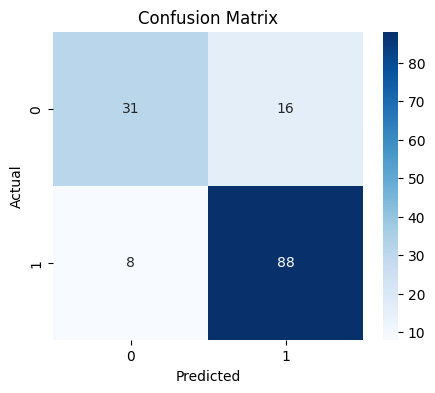

In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

The logistic regression model is performing well, achieving a high F1-score (\~0.90) with strong recall for the positive class and balanced precision. The confusion matrix shows consistent prediction accuracy across classes, indicating that the model is correctly capturing the underlying patterns in the data.


## Machine Learning Explainability

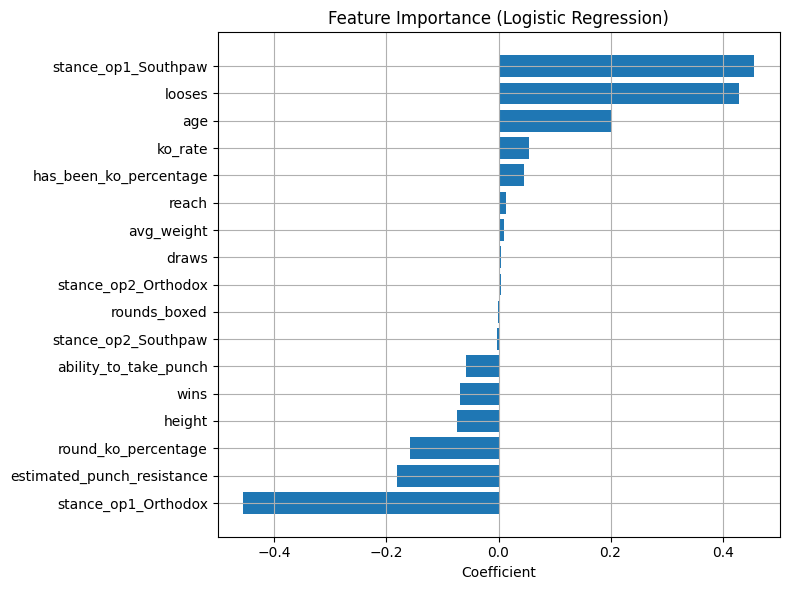

In [30]:
pipeline.fit(X, y)
model = pipeline.named_steps['model']
coef = model.coef_[0]


X_transformed = pipeline.named_steps['preprocessor'].transform(X)

# Extracting numeric columns names
num_features = []
for col in X.columns:
    if col.endswith('2'):
        num_features.append(re.search(r'([a-z_]+)(_op2$)',col).group(1))
num_features.pop(num_features.index('stance'))

# Extrcting categories names
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_features = ohe.get_feature_names_out(categorical_cols)

# Union all
feature_names = list(num_features) + list(cat_features)

pd.DataFrame({'feature': feature_names, 'coef': coef}).sort_values('coef')

df_coef = pd.DataFrame({'feature': feature_names, 'coef': coef})
df_coef = df_coef.sort_values('coef')

# Creating a feature importance plot
plt.figure(figsize=(8,6))
plt.barh(df_coef['feature'], df_coef['coef'])
plt.title("Feature Importance (Logistic Regression)")
plt.xlabel("Coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()

### The most important features for logistic regression was:

- Stance: Increased win chance by 40% for Southpaw Stance. Reduces win chance by 40% for Orthodox Stance
- Looses
- Age
- Estimated punch resistance
- Round KO Percentage
- Height
- Wins